In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Retailprices = pd.read_csv("MonthlyRetailPrices.csv")

Retailprices.head()

,Products,Jan-17,Feb-17,Mar-17,Apr-17,May-17,Jun-17,Jul-17,Aug-17,Sep-17,...,Dec-24,Jan-25,Feb-25,Mar-25,Apr-25,May-25,Jun-25,Jul-25,Aug-25,Sep-25
0,"Beef stewing cuts, per kilogram 5",12.66,13.12,13.51,13.29,14.08,14.10,14.44,14.35,13.62,...,20.58,18.01,19.69,19.33,20.65,20.90,23.29,23.61,21.08,23.28
1,"Beef striploin cuts, per kilogram 5",21.94,22.51,23.23,19.59,23.04,23.34,23.83,20.63,23.23,...,24.44,27.80,28.05,35.00,32.81,30.33,26.06,30.24,30.80,30.18
2,"Beef top sirloin cuts, per kilogram 5",13.44,12.80,13.96,12.40,16.91,15.70,15.69,15.80,15.09,...,19.59,23.19,22.79,22.06,26.20,25.45,24.81,29.40,28.25,27.54
3,"Beef rib cuts, per kilogram 5",20.17,20.13,22.95,17.47,18.80,21.36,21.17,21.30,20.40,...,25.20,28.95,32.79,39.01,28.21,32.57,32.31,31.99,33.43,33.67
4,"Ground beef, per kilogram 5",9.12,9.48,9.34,9.79,9.47,9.18,10.03,9.79,9.61,...,14.25,13.08,13.91,13.85,14.17,14.67,14.73,14.78,15.06,14.85


In [3]:
R2017= Retailprices.groupby(by='Products')[['Jan-17','Feb-17','Mar-17','Apr-17','May-17','Jun-17','Jul-17','Aug-17','Sep-17', 'Oct-17','Nov-17','Dec-17']].mean()

In [4]:
import re
import pandas as pd

# --- replace Retailprices with your actual df variable name if different ---
df = Retailprices.copy()

# Identify product column (assumes first column is product name)
product_col = df.columns[0]

# All other columns are assumed to be month columns
month_cols = list(df.columns[1:])

# Function to extract year (handles 'Jan-17', 'Jan 2017', 'January 2017', 'Dec-24', '2025-05', etc.)
def extract_year(colname):
    s = str(colname).strip()
    # try find 4-digit year first
    m = re.search(r'(20\d{2}|19\d{2})', s)
    if m:
        return int(m.group(1))
    # try 2-digit year at end, e.g. 'Jan-17' -> 2017
    m2 = re.search(r'(\d{2})\s*$', s)
    if m2:
        y2 = int(m2.group(1))
        # assume 2000s for your dataset (adjust if you have 1900s)
        return 2000 + y2
    # fallback: try splitting and take last token as int
    parts = re.split(r'[\s\-_/]', s)
    for p in reversed(parts):
        if p.isdigit() and len(p) == 4:
            return int(p)
    # if nothing found, return None so we can debug
    return None

# Build mapping year -> list of month columns
year_cols = {}
for col in month_cols:
    yr = extract_year(col)
    if yr is None:
        raise ValueError(f"Could not extract year from column name: {col!r}")
    year_cols.setdefault(yr, []).append(col)

# Compute yearly means into a dict (preserve row order)
avg_dict = {}
for yr, cols in sorted(year_cols.items()):
    # mean across months for each product (skip NaNs)
    avg_dict[str(yr)] = df[cols].mean(axis=1, skipna=True)

# Combine product column + yearly means into final dataframe
price_average_per_year = pd.concat([df[[product_col]].reset_index(drop=True),
                                    pd.DataFrame(avg_dict).reset_index(drop=True)], axis=1)

# Optional: compute period means (Pre/During/Post) using your periods
pre_years = [str(y) for y in range(2015, 2020)]    # 2015-2019
during_years = [str(2020), str(2021)]
post_years = [str(y) for y in range(2022, 2026)]   # adjust 2025 inclusive

# only include years that exist in avg_dict
def safe_mean(row, year_list):
    existing = [y for y in year_list if y in price_average_per_year.columns]
    if not existing:
        return float('nan')
    return row[existing].mean()

price_average_per_year['Pre-AI_Mean'] = price_average_per_year.apply(lambda r: safe_mean(r, pre_years), axis=1)
price_average_per_year['During-AI_Mean'] = price_average_per_year.apply(lambda r: safe_mean(r, during_years), axis=1)
price_average_per_year['Post-AI_Mean'] = price_average_per_year.apply(lambda r: safe_mean(r, post_years), axis=1)

In [5]:
price_average_per_year

,Products,2017,2018,2019,2020,2021,2022,2023,2024,2025,Pre-AI_Mean,During-AI_Mean,Post-AI_Mean
0,"Beef stewing cuts, per kilogram 5",13.652500,13.284167,14.009167,15.532500,15.941667,18.125833,18.376667,19.203333,21.093333,13.648611,15.737083,19.199792
1,"Beef striploin cuts, per kilogram 5",21.212500,19.383333,19.174167,22.135833,24.206667,25.019167,26.256667,27.332500,30.141111,19.923333,23.171250,27.187361
2,"Beef top sirloin cuts, per kilogram 5",14.314167,14.443333,15.046667,15.916667,16.615000,18.568333,21.565833,21.995000,25.521111,14.601389,16.265833,21.912569
3,"Beef rib cuts, per kilogram 5",19.693333,19.856667,20.960000,22.504167,25.200000,26.447500,27.907500,30.165833,32.547778,20.170000,23.852083,29.267153
4,"Ground beef, per kilogram 5",9.446667,9.137500,9.220833,9.994167,9.705833,10.545000,11.275000,12.591667,14.344444,9.268333,9.850000,12.189028
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,"Pasta sauce, 650 millilitres 6",2.091667,2.115000,2.185833,2.343333,2.445000,2.750000,3.148333,3.202500,3.268889,2.130833,2.394167,3.092431
102,"Salad dressing, 475 millilitres 6",2.390833,2.405833,2.472500,2.580833,2.747500,3.270833,3.409167,3.387500,3.432222,2.423056,2.664167,3.374931
103,"Almonds, 200 grams 6",4.385833,4.876667,5.095833,5.188333,5.162500,5.251667,4.842500,4.554167,4.958889,4.786111,5.175417,4.901806
104,"Peanuts, 450 grams 6",3.423333,3.370833,3.197500,3.267500,3.200833,3.320000,3.726667,3.951667,4.130000,3.330556,3.234167,3.782083


### __SELECTED FOOD TRENDS__

__Price trend in milk__

In [6]:
milk_price_trend = (price_average_per_year.iloc[20, :-3])
milk_price_trend

milk_df = pd.DataFrame(data=[milk_price_trend.values], columns=milk_price_trend.index)

milk_df.reset_index(drop=True, inplace=True)

milk_df

,Products,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,"Milk, 2 litres 5",4.0325,4.095833,4.18,4.335833,4.473333,4.779167,5.070833,5.2125,5.368889


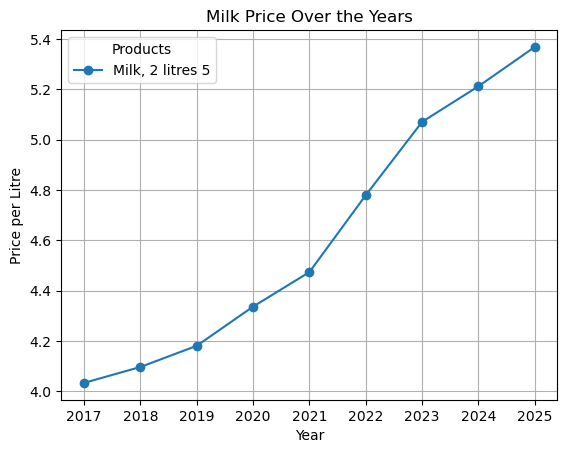

In [7]:
milk_df.set_index("Products").T.plot(kind="line", marker="o")
plt.title("Milk Price Over the Years")
plt.xlabel("Year")
plt.ylabel("Price per Litre")
plt.grid(True)
plt.show()

In [8]:
milk_ai_trend = price_average_per_year.iloc[20, -3:]

milk_ai_trend

Pre-AI_Mean       4.102778
During-AI_Mean    4.404583
Post-AI_Mean      5.107847
Name: 20, dtype: object

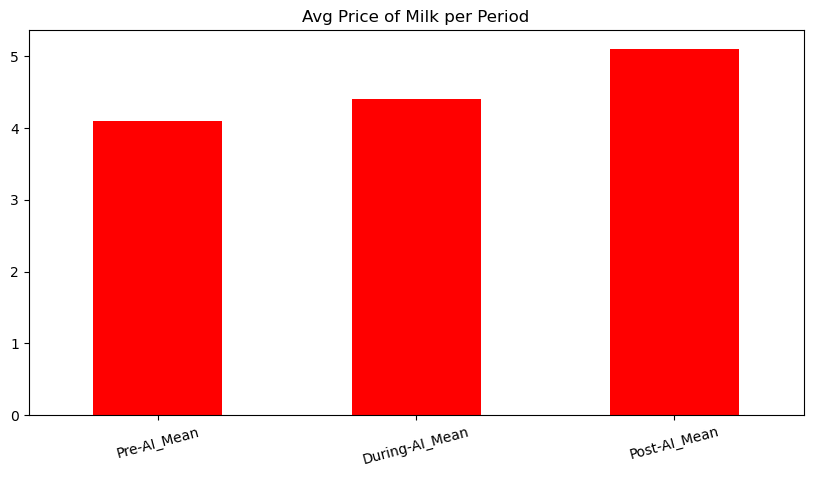

In [9]:
plt.figure(figsize=(10, 5))
milk_ai_trend.plot(kind= 'bar', color= 'red', title = 'Avg Price of Milk per Period')
plt.xticks(rotation = 15)
plt.show()

__Orange Price Trend__

In [10]:
orange_price_trend = (price_average_per_year.iloc[31, :-3])
orange_price_trend

orange_df = pd.DataFrame(data=[orange_price_trend.values], columns= orange_price_trend.index)

orange_df.reset_index(drop=True, inplace=True)

orange_df

,Products,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,"Oranges, per kilogram 5",3.2325,3.281667,3.406667,3.6875,3.690833,4.191667,4.263333,3.941667,4.617778


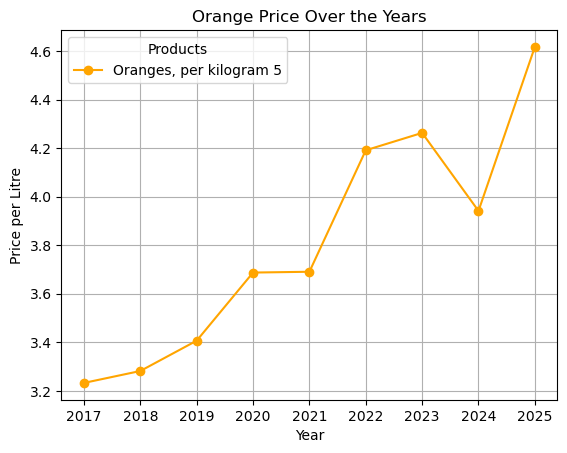

In [11]:
orange_df.set_index("Products").T.plot(kind="line", marker="o", color='orange')
plt.title("Orange Price Over the Years")
plt.xlabel("Year")
plt.ylabel("Price per Litre")
plt.grid(True)
plt.show()

In [12]:
orange_ai_trend = price_average_per_year.iloc[31, -3:]

orange_ai_trend

Pre-AI_Mean       3.306944
During-AI_Mean    3.689167
Post-AI_Mean      4.253611
Name: 31, dtype: object

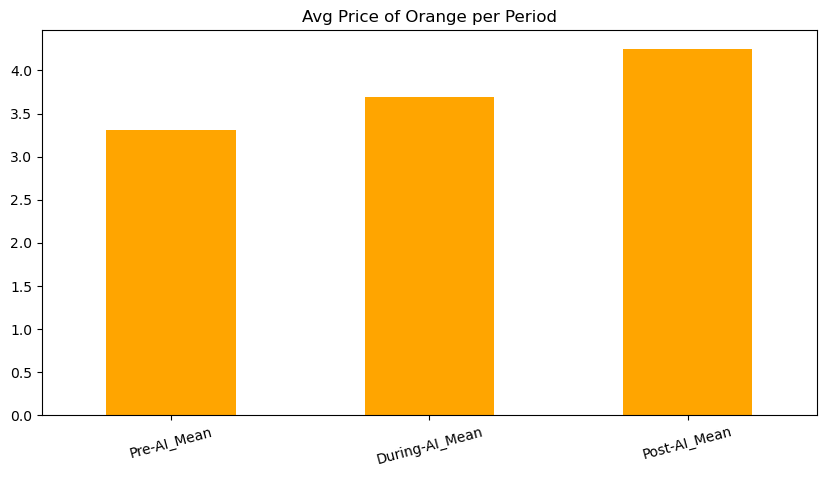

In [13]:
plt.figure(figsize=(10, 5))
orange_ai_trend.plot(kind= 'bar', color= 'orange', title = 'Avg Price of Orange per Period')
plt.xticks(rotation = 15)
plt.show()

__Egg Price Trend__

In [14]:
egg_price_trend = (price_average_per_year.iloc[29, :-3])
egg_price_trend

egg_df = pd.DataFrame(data=[egg_price_trend.values], columns= egg_price_trend.index)

egg_df.reset_index(drop=True, inplace=True)

egg_df

,Products,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,"Eggs, 1 dozen 5",3.11,3.280833,3.401667,3.721667,4.0025,4.289167,4.511667,4.600833,4.907778


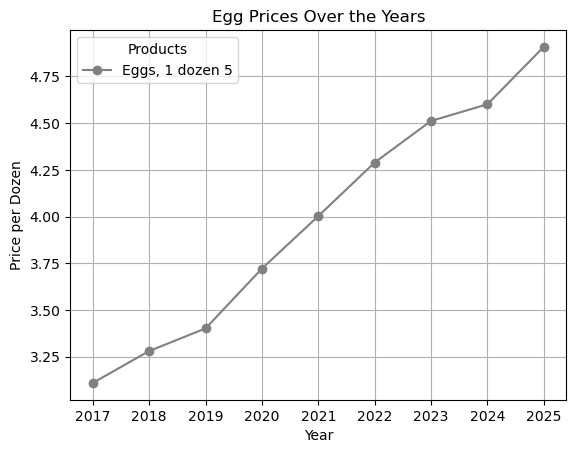

In [15]:
egg_df.set_index("Products").T.plot(kind="line", marker="o", color='grey')
plt.title("Egg Prices Over the Years")
plt.xlabel("Year")
plt.ylabel("Price per Dozen")
plt.grid(True)
plt.show()

In [16]:
egg_ai_trend = price_average_per_year.iloc[29, -3:]

egg_ai_trend

Pre-AI_Mean       3.264167
During-AI_Mean    3.862083
Post-AI_Mean      4.577361
Name: 29, dtype: object

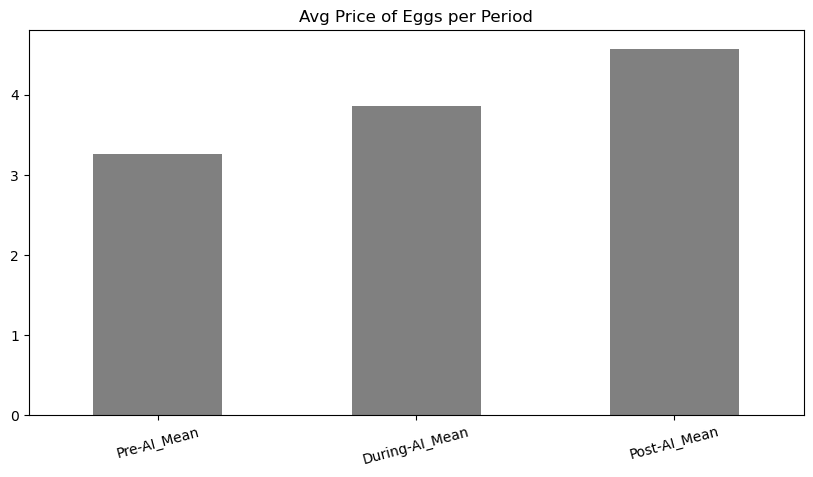

In [17]:
plt.figure(figsize=(10, 5))
egg_ai_trend.plot(kind= 'bar', color= 'grey', title = 'Avg Price of Eggs per Period')
plt.xticks(rotation = 15)
plt.show()

In [18]:
bread_price_trend = (price_average_per_year.iloc[67, :-3])
bread_price_trend

bread_df = pd.DataFrame(data=[bread_price_trend.values], columns= bread_price_trend.index)

bread_df.reset_index(drop=True, inplace=True)

bread_df

,Products,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,"White bread, 675 grams 6",2.841667,2.8075,2.870833,2.970833,3.005,3.403333,3.588333,3.438333,3.468889


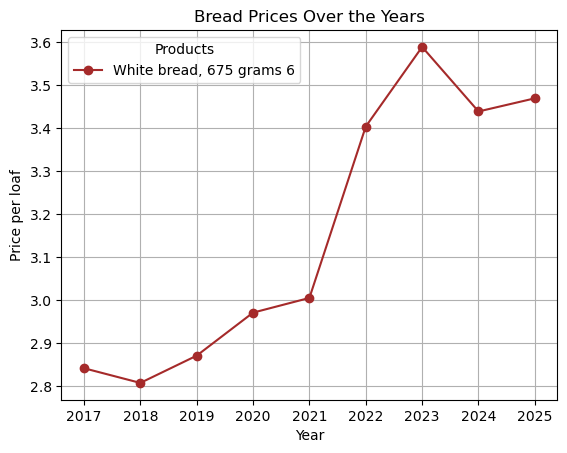

In [19]:
bread_df.set_index("Products").T.plot(kind="line", marker="o", color='brown')
plt.title("Bread Prices Over the Years")
plt.xlabel("Year")
plt.ylabel("Price per loaf")
plt.grid(True)
plt.show()

In [20]:
bread_ai_trend = price_average_per_year.iloc[67, -3:]

bread_ai_trend

Pre-AI_Mean           2.84
During-AI_Mean    2.987917
Post-AI_Mean      3.474722
Name: 67, dtype: object

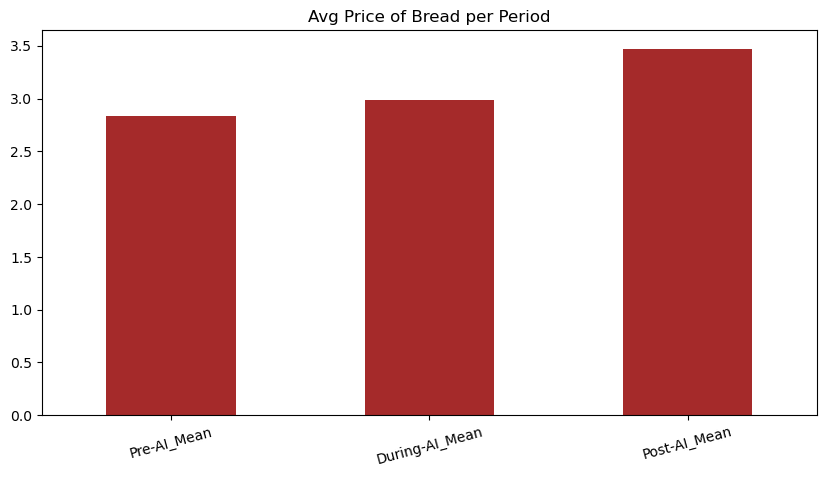

In [21]:
plt.figure(figsize=(10, 5))
bread_ai_trend.plot(kind= 'bar', color= 'brown', title = 'Avg Price of Bread per Period')
plt.xticks(rotation = 15)
plt.show()

In [22]:
pre_ai_years = ['2017', '2018', '2019']
ai_acceleration_years = ['2020', '2021', '2022']
post_ai_years = ['2023', '2024', '2025']

volatility_df = pd.DataFrame({
    'Product':price_average_per_year['Products'],
    'Pre_AI_Volatility': price_average_per_year[pre_ai_years].std(axis=1),
    'AI_Acceleration_Volatility': price_average_per_year[ai_acceleration_years].std(axis=1),
    'Post_AI_Volatility': price_average_per_year[post_ai_years].std(axis=1)
})


volatility_df

,Product,Pre_AI_Volatility,AI_Acceleration_Volatility,Post_AI_Volatility
0,"Beef stewing cuts, per kilogram 5",0.362516,1.394237,1.392585
1,"Beef striploin cuts, per kilogram 5",1.121339,1.486726,2.005601
2,"Beef top sirloin cuts, per kilogram 5",0.390993,1.374440,2.170325
3,"Beef rib cuts, per kilogram 5",0.689017,2.015509,2.320413
4,"Ground beef, per kilogram 5",0.159963,0.426371,1.539877
...,...,...,...,...
101,"Pasta sauce, 650 millilitres 6",0.049039,0.211636,0.060381
102,"Salad dressing, 475 millilitres 6",0.043472,0.360036,0.022365
103,"Almonds, 200 grams 6",0.363559,0.045879,0.208360
104,"Peanuts, 450 grams 6",0.118182,0.059724,0.202116


If Post-AI volatility is higher than Pre-AI, it suggests AI-era disruptions increased price instability.

If it’s lower, automation might have stabilized supply chains for that product.

Volatility in Food Prices

In this dataset, volatility = price instability or fluctuation — how much the price of a food product varies over time.

Mathematically, you’re using the standard deviation of monthly prices within each period (Pre-AI, During-AI, Post-AI).

So:

High volatility → prices swing up and down a lot → less predictable and less affordable for consumers.

Low volatility → prices are relatively stable → consumers and producers can plan better.

🧠 In your story:

If volatility increased post-AI, it might suggest that AI-driven changes (automation, predictive logistics, etc.) did not stabilize food prices as expected — or that AI adoption coincided with external shocks (supply chain issues, inflation).

If volatility decreased post-AI, it implies AI improved price stability, possibly through better forecasting, supply optimization, and distribution efficiency.

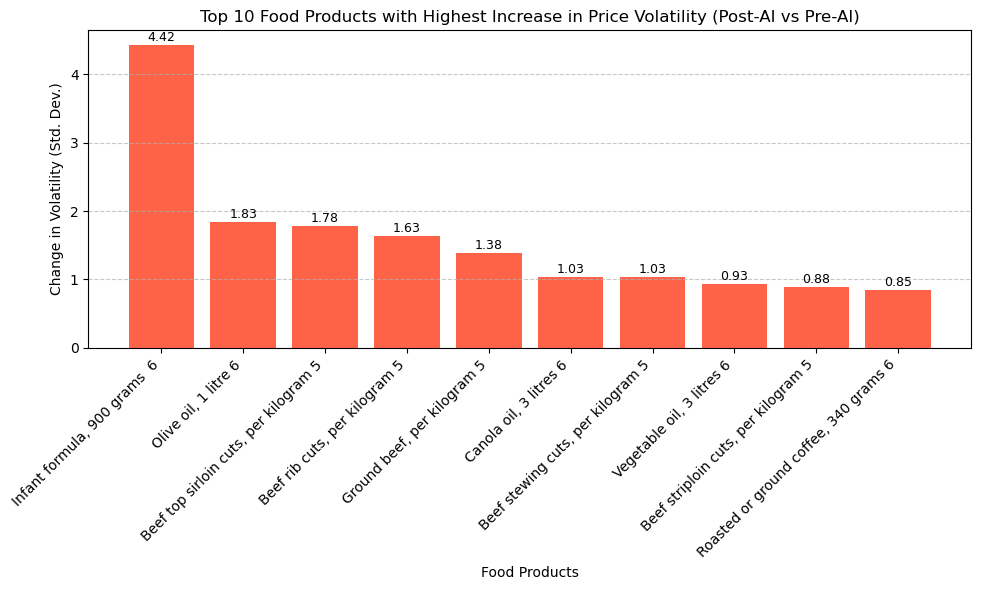

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Calculate the change in volatility between Post-AI and Pre-AI
volatility_df['Volatility_Change'] = volatility_df['Post_AI_Volatility'] - volatility_df['Pre_AI_Volatility']

# 2️⃣ Sort by largest increase
top10_volatility = volatility_df.sort_values(by='Volatility_Change', ascending=False).head(10)

# 3️⃣ Plot
plt.figure(figsize=(10,6))
bars = plt.bar(top10_volatility['Product'], top10_volatility['Volatility_Change'], color='tomato')

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

# 4️⃣ Formatting
plt.title("Top 10 Food Products with Highest Increase in Price Volatility (Post-AI vs Pre-AI)", fontsize=12)
plt.xlabel("Food Products", fontsize=10)
plt.ylabel("Change in Volatility (Std. Dev.)", fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

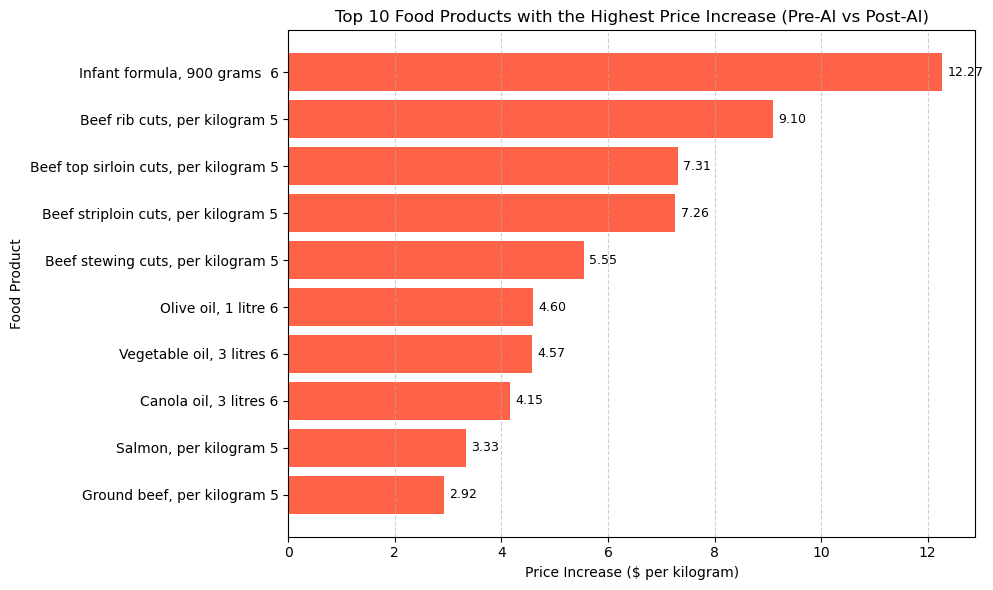

In [24]:
price_average_per_year['Price_Change'] = price_average_per_year['Post-AI_Mean'] - price_average_per_year['Pre-AI_Mean']
price_average_per_year['Percent_Change'] = (price_average_per_year['Price_Change'] / price_average_per_year['Pre-AI_Mean']) * 100


top10_increase = price_average_per_year.sort_values(by='Price_Change', ascending=False).head(10)


plt.figure(figsize=(10,6))
bars = plt.barh(top10_increase['Products'], top10_increase['Price_Change'], color='tomato')
plt.gca().invert_yaxis()


for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=9)


plt.title("Top 10 Food Products with the Highest Price Increase (Pre-AI vs Post-AI)", fontsize=12)
plt.xlabel("Price Increase ($ per kilogram)", fontsize=10)
plt.ylabel("Food Product", fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [25]:
category_map = {
    'Animal Products (Meat, Poultry, Seafood)': [
        'beef', 'pork', 'chicken', 'bacon', 'wiener', 'salmon', 'shrimp', 'tuna', 'meatless'
    ],
    'Dairy and Alternatives': [
        'milk', 'soy milk', 'nut milk', 'yogurt', 'butter', 'margarine', 'cheese', 'cream'
    ],
    'Eggs and Proteins': [
        'egg', 'tofu', 'peanut', 'almond', 'hummus', 'sunflower', 'seeds'
    ],
    'Fruits and Vegetables': [
        'apple', 'banana', 'orange', 'pear', 'lemon', 'lime', 'grape', 'cantaloupe',
        'strawberry', 'avocado', 'potato', 'sweet potato', 'tomato', 'cabbage', 'carrot',
        'onion', 'celery', 'cucumber', 'mushroom', 'lettuce', 'broccoli', 'pepper',
        'squash', 'greens', 'corn', 'spinach', 'vegetable', 'frozen', 'salad'
    ],
    'Grains, Bread, and Cereals': [
        'rice', 'bread', 'pasta', 'flour', 'cereal', 'pita', 'flatbread', 'cracker',
        'cookie', 'biscuit', 'wheat'
    ],
    'Beverages': [
        'juice', 'coffee', 'tea'
    ],
    'Oils, Condiments, and Sauces': [
        'oil', 'ketchup', 'mayonnaise', 'salsa', 'pasta sauce', 'salad dressing'
    ],
    'Canned and Packaged Foods': [
        'canned', 'infant formula', 'baby food', 'lentil', 'bean', 'soup', 'peach', 'pear'
    ]
}

# Function to assign a category
def categorize_product(product):
    product_lower = product.lower()
    for category, keywords in category_map.items():
        if any(keyword in product_lower for keyword in keywords):
            return category
    return 'Other'

# Apply the categorization
Retailprices['Category'] = Retailprices['Products'].apply(categorize_product)

# Check the distribution
print(Retailprices['Category'].value_counts())

Category
Fruits and Vegetables                       43
Animal Products (Meat, Poultry, Seafood)    19
Dairy and Alternatives                      11
Grains, Bread, and Cereals                  10
Canned and Packaged Foods                    8
Eggs and Proteins                            6
Oils, Condiments, and Sauces                 5
Other                                        2
Beverages                                    2
Name: count, dtype: int64


In [26]:
Retailprices.head()

,Products,Jan-17,Feb-17,Mar-17,Apr-17,May-17,Jun-17,Jul-17,Aug-17,Sep-17,...,Jan-25,Feb-25,Mar-25,Apr-25,May-25,Jun-25,Jul-25,Aug-25,Sep-25,Category
0,"Beef stewing cuts, per kilogram 5",12.66,13.12,13.51,13.29,14.08,14.10,14.44,14.35,13.62,...,18.01,19.69,19.33,20.65,20.90,23.29,23.61,21.08,23.28,"Animal Products (Meat, Poultry, Seafood)"
1,"Beef striploin cuts, per kilogram 5",21.94,22.51,23.23,19.59,23.04,23.34,23.83,20.63,23.23,...,27.80,28.05,35.00,32.81,30.33,26.06,30.24,30.80,30.18,"Animal Products (Meat, Poultry, Seafood)"
2,"Beef top sirloin cuts, per kilogram 5",13.44,12.80,13.96,12.40,16.91,15.70,15.69,15.80,15.09,...,23.19,22.79,22.06,26.20,25.45,24.81,29.40,28.25,27.54,"Animal Products (Meat, Poultry, Seafood)"
3,"Beef rib cuts, per kilogram 5",20.17,20.13,22.95,17.47,18.80,21.36,21.17,21.30,20.40,...,28.95,32.79,39.01,28.21,32.57,32.31,31.99,33.43,33.67,"Animal Products (Meat, Poultry, Seafood)"
4,"Ground beef, per kilogram 5",9.12,9.48,9.34,9.79,9.47,9.18,10.03,9.79,9.61,...,13.08,13.91,13.85,14.17,14.67,14.73,14.78,15.06,14.85,"Animal Products (Meat, Poultry, Seafood)"


In [27]:
Retailprices_melted = Retailprices.melt(
    id_vars=['Products', 'Category'], 
    var_name='Month_Year', 
    value_name='Average Price'
)


Retailprices_melted['Year'] = Retailprices_melted['Month_Year'].str[-2:].astype(int)
Retailprices_melted['Year'] = 2000 + Retailprices_melted['Year']  # convert to full year


category_year_mean = (
    Retailprices_melted
    .groupby(['Category', 'Year'])['Average Price']
    .mean()
    .reset_index()
)


category_year_mean

,Category,Year,Average Price
0,"Animal Products (Meat, Poultry, Seafood)",2017,9.425044
1,"Animal Products (Meat, Poultry, Seafood)",2018,9.369123
2,"Animal Products (Meat, Poultry, Seafood)",2019,9.752193
3,"Animal Products (Meat, Poultry, Seafood)",2020,10.213114
4,"Animal Products (Meat, Poultry, Seafood)",2021,10.800614
...,...,...,...
76,Other,2021,3.177917
77,Other,2022,3.579583
78,Other,2023,3.657083
79,Other,2024,3.594167


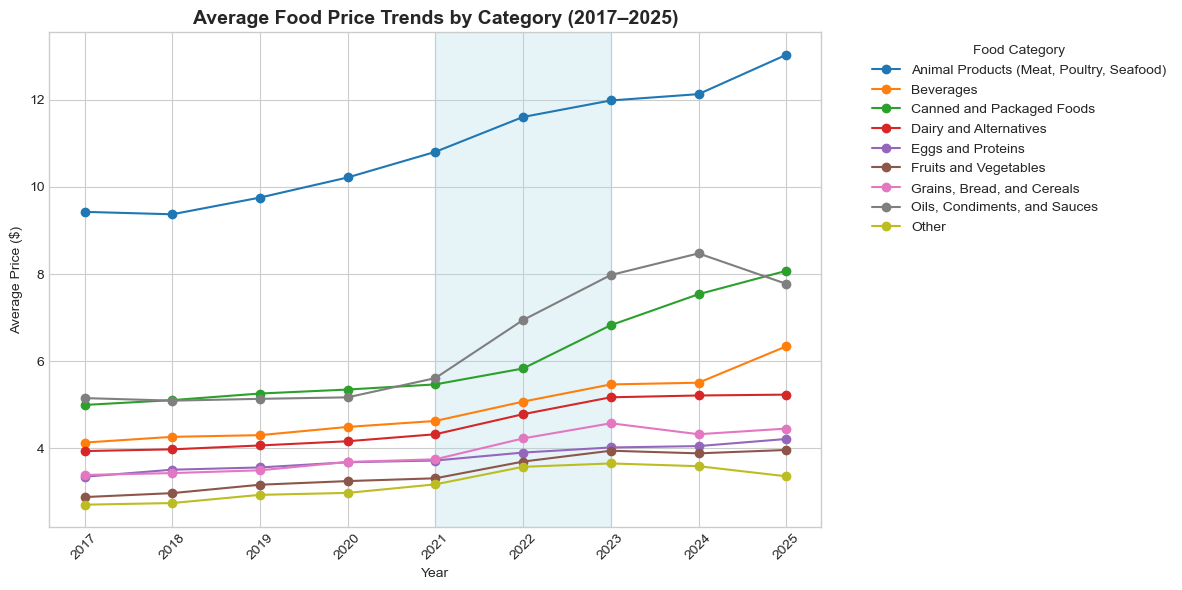

In [28]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot each category’s average price trend
for category in category_year_mean['Category'].unique():
    subset = category_year_mean[category_year_mean['Category'] == category]
    plt.plot(subset['Year'], subset['Average Price'], marker='o', label=category)

# Titles and labels
plt.title('Average Food Price Trends by Category (2017–2025)', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Price ($)')
plt.legend(title='Food Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Optional: highlight the "AI era"
plt.axvspan(2021, 2023, color='lightblue', alpha=0.3, label='AI Adoption Era')

# Display the chart
plt.tight_layout()
plt.show()

In [29]:
def classify_ai_period(year):
    if 2017 <= year <= 2019:
        return 'Pre-AI'
    elif 2020 <= year <= 2021:
        return 'During-AI'
    elif year >= 2022:
        return 'Post-AI'
    else:
        return 'Unknown'

category_year_mean['AI_Period'] = category_year_mean['Year'].apply(classify_ai_period)

In [30]:
category_year_mean

,Category,Year,Average Price,AI_Period
0,"Animal Products (Meat, Poultry, Seafood)",2017,9.425044,Pre-AI
1,"Animal Products (Meat, Poultry, Seafood)",2018,9.369123,Pre-AI
2,"Animal Products (Meat, Poultry, Seafood)",2019,9.752193,Pre-AI
3,"Animal Products (Meat, Poultry, Seafood)",2020,10.213114,During-AI
4,"Animal Products (Meat, Poultry, Seafood)",2021,10.800614,During-AI
...,...,...,...,...
76,Other,2021,3.177917,During-AI
77,Other,2022,3.579583,Post-AI
78,Other,2023,3.657083,Post-AI
79,Other,2024,3.594167,Post-AI


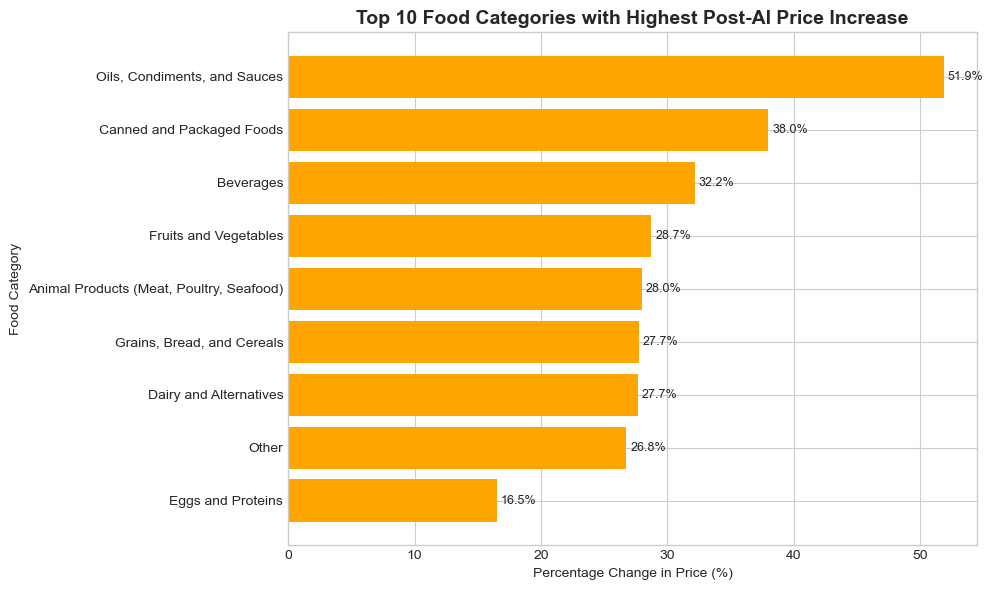

In [31]:
category_ai_mean = (
   category_year_mean.groupby(['Category', 'AI_Period'])['Average Price']
    .mean()
    .reset_index()
)

# Step 2 — Pivot to compare Pre-AI vs Post-AI prices
category_ai_mean_pivot = (
    category_ai_mean.pivot(index='Category', columns='AI_Period', values='Average Price')
    .reset_index()
)

# Step 3 — Calculate percentage change (Post vs Pre)
category_ai_mean_pivot['% Change'] = (
    (category_ai_mean_pivot['Post-AI'] - category_ai_mean_pivot['Pre-AI'])
    / category_ai_mean_pivot['Pre-AI']
) * 100

# Step 4 — Sort by % change
category_ai_mean_pivot = category_ai_mean_pivot.sort_values('% Change', ascending=False)

# Step 5 — Plot top 10 categories
top10 = category_ai_mean_pivot.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top10['Category'], top10['% Change'], color='orange')
plt.gca().invert_yaxis()

# Titles and labels
plt.title('Top 10 Food Categories with Highest Post-AI Price Increase', fontsize=14, fontweight='bold')
plt.xlabel('Percentage Change in Price (%)')
plt.ylabel('Food Category')

# Add text labels
for i, v in enumerate(top10['% Change']):
    plt.text(v + 0.3, i, f"{v:.1f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()